In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

In [2]:
# Отключаем скроллер

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
pd.set_option('display.max_columns', 100 )
pd.set_option('display.max_rows', 100)

In [5]:
df = pd.read_csv('data/flight_delays_train.csv')

# Первичный анализ данных

Датасет с данными по авиаперелетам Америки за 2018 год.

Целью анализа является прогнозирование задержек посадки самолетов на 15 минут.

Каждая строка таблицы данных описывает перелет, остановимся подробнее на описании признаков (столбцов таблицы):

1. Month - месяца перелета
2. DayOfMonth - день месяца
3. DayOfWeek - день недели
4. DepTime - время прибытия самолета в формате (hhmm)
5. UniqueCarrier - авиакомпания
6. Origin - индекс аэропорта вылета
7. Dest - индекс аэропорта прилета
8. Distance - растояние между аэропортами (киллометры)
9. dep_delayed_15min - признак задержки прибытия ('Y' - посадка с задержкой / 'N' - посадка без задержки)

In [6]:
df

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,c-5,c-4,c-3,1618,OO,SFO,RDD,199,N
99996,c-1,c-18,c-3,804,CO,EWR,DAB,884,N
99997,c-1,c-24,c-2,1901,NW,DTW,IAH,1076,N
99998,c-4,c-27,c-4,1515,MQ,DFW,GGG,140,N


Авиакомпании

In [7]:
print(df['UniqueCarrier'].unique())

['AA' 'US' 'XE' 'OO' 'WN' 'NW' 'DL' 'OH' 'AS' 'UA' 'MQ' 'CO' 'EV' 'DH'
 'YV' 'F9' 'AQ' 'TZ' 'HP' 'B6' 'FL' 'HA']


Расшифровка аббревиатур авиакомпаний

'AA' - American Airlines  
'US' - US Airways  
'XE' - Express Jet  
'OO' - SkyWest Airlines  
'WN' - Southwest Airlines  
'NW' - Northwest Airlines  
'DL' - Delta Air Lines  
'OH' - Comair  
'AS' - Alaska Airlines  
'UA' - United Airlines  
'MQ' - American Eagle Airlines  
'CO' - Cobalt Air  
'EV' - EVA Airways Corporation  
'DH' - Dennis Sky  
'YV' - Yamal Airlines  
'F9' - Frontier Airlines  
'AQ' - Aloha Airlines  
'TZ' - Scoot  
'HP' - America West Airlines  
'B6' - JetBlue Airways  
'FL' - iFly Airlines  
'HA' - Hawaiian Airlines  

In [8]:
print(df['Origin'].unique())

['ATL' 'PIT' 'RDU' 'DEN' 'MDW' 'MEM' 'PBI' 'MSP' 'ONT' 'BDL' 'PHX' 'LAS'
 'DFW' 'DSM' 'CMH' 'ORF' 'SLC' 'CLT' 'GSO' 'IAD' 'SMF' 'FLL' 'DAL' 'ORD'
 'ITO' 'SAN' 'ROA' 'LGA' 'SFO' 'GSP' 'SEA' 'DAB' 'SJC' 'LIT' 'LAX' 'OAK'
 'COS' 'OKC' 'GRR' 'JFK' 'BOI' 'MCI' 'BWI' 'BHM' 'CRP' 'BOS' 'SAT' 'PHL'
 'STL' 'CIC' 'AUS' 'IAH' 'COD' 'HNL' 'RNO' 'BNA' 'TPA' 'MIA' 'EVV' 'PNS'
 'EWR' 'RSW' 'ANC' 'SNA' 'AMA' 'CID' 'DTW' 'DCA' 'LGB' 'MAF' 'MFE' 'BMI'
 'PDX' 'IPL' 'GRB' 'FAR' 'HOU' 'MTJ' 'DRO' 'MLU' 'VPS' 'TUL' 'CVG' 'SBA'
 'PWM' 'IDA' 'MCO' 'ACV' 'CHS' 'BGM' 'MSY' 'OGG' 'CLE' 'MOB' 'CAK' 'FAY'
 'SHV' 'TUS' 'IND' 'CAE' 'PVD' 'ROC' 'MFR' 'VLD' 'ELP' 'RIC' 'MKE' 'SGF'
 'TYS' 'CHO' 'EGE' 'BIS' 'JAN' 'JAX' 'BUF' 'MSO' 'BGR' 'CEC' 'ICT' 'MYR'
 'ALB' 'LIH' 'SBP' 'AEX' 'GNV' 'SAV' 'BTM' 'BRO' 'SJU' 'XNA' 'CPR' 'SDF'
 'JAC' 'AVL' 'PHF' 'GPT' 'SYR' 'PSP' 'MHT' 'MRY' 'CLD' 'FAT' 'MSN' 'ISP'
 'BUR' 'PSC' 'MEI' 'LEX' 'LBB' 'GEG' 'LFT' 'OMA' 'ISO' 'MGM' 'GRK' 'AVP'
 'ABQ' 'SRQ' 'BTV' 'FLG' 'BTR' 'MDT' 'ABI' 'TRI' 'A

Расшифровку индексов аэропортов можно найти здесь https://ru.wikipedia.org/wiki/Список_аэропортов_США

In [9]:
df.describe()

,DepTime,Distance
count,100000.000000,100000.00000
mean,1341.523880,729.39716
std,476.378445,574.61686
min,1.000000,30.00000
25%,931.000000,317.00000
50%,1330.000000,575.00000
75%,1733.000000,957.00000
max,2534.000000,4962.00000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


# Предобработка информации 

Значения некорых числовых признаков, таких как месяц день и день недели, имеют тип данных object, а именно тип <class 'str'>  

Формат временных данных имеет вид c-{number} соответственно необходимо избавиться от лишних символов перед числом

In [11]:
print('Type = ', type(df['Month'][0]),' Value = ', df['Month'][0])

Type =  <class 'str'>  Value =  c-8


Также было бы неплохо сформировать новый признак, объединяющий данные времени в единую дату формата Datetime

Значения признака DepTime выходят за рамки допустимого диапазон значений (от 0000 до 2359), максимум достигается в 2534 (см. данные df.describe()). 

Исправим неверные данные - заменим '25xx' на '01xx' и '24xx' на '00xx'

Признак задержки переведем в бинарный формат ('0' - без задержки, '1' - с задержкой)

In [12]:
def preprocess_date(date):   

    if type(date.values[0]) == type('str'):
        date = date.apply(lambda d: int(d[2:]))
        
    return date

In [13]:
def preprocess_delay_flag(delay):
    
    if type(delay.values[0]) == type('str'):
        delay = delay.apply(lambda d: 1 if d == 'Y' else 0)
        
    return delay

In [14]:
def correct_dep_time(time):
    
    if time//100 == 25:
        return time%100 + 100
    elif time//100 == 24:
        return time%100
    else:
        return time

In [15]:
df['Month'] = preprocess_date(df['Month'])

df['Day'] = preprocess_date(df['DayofMonth'])

df['DayOfWeek'] = preprocess_date(df['DayOfWeek'])

df['delay'] = preprocess_delay_flag(df['dep_delayed_15min'])

df['Year'] = np.zeros(df.shape[0])+2018

df['DepTime'] = df['DepTime'].apply(correct_dep_time)

df['Hour'] = df['DepTime'].apply(lambda h: h//100)

df['Minute'] = df['DepTime'].apply(lambda h: h%100)

date = pd.DataFrame({'year': df['Year'],
                     'month': df['Month'],
                     'day': df['Day'],
                     'hour': df['Hour'],
                     'minute': df['Minute']})

df['Date'] = pd.to_datetime(date)

df = df[['Month', 'Day', 'Hour', 'Minute', 'DayOfWeek', 'Distance', 'UniqueCarrier',\
         'Origin', 'Dest', 'delay', 'DepTime', 'Date']]

Новая обработанная таблица имеет вид

In [16]:
df

,Month,Day,Hour,Minute,DayOfWeek,Distance,UniqueCarrier,Origin,Dest,delay,DepTime,Date
0,8,21,19,34,7,732,AA,ATL,DFW,0,1934,2018-08-21 19:34:00
1,4,20,15,48,3,834,US,PIT,MCO,0,1548,2018-04-20 15:48:00
2,9,2,14,22,5,416,XE,RDU,CLE,0,1422,2018-09-02 14:22:00
3,11,25,10,15,6,872,OO,DEN,MEM,0,1015,2018-11-25 10:15:00
4,10,7,18,28,6,423,WN,MDW,OMA,1,1828,2018-10-07 18:28:00
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,4,16,18,3,199,OO,SFO,RDD,0,1618,2018-05-04 16:18:00
99996,1,18,8,4,3,884,CO,EWR,DAB,0,804,2018-01-18 08:04:00
99997,1,24,19,1,2,1076,NW,DTW,IAH,0,1901,2018-01-24 19:01:00
99998,4,27,15,15,4,140,MQ,DFW,GGG,0,1515,2018-04-27 15:15:00


# Визуализация данных

Покажем общее количество задержек по месяцам, дням, часам, и дням недели

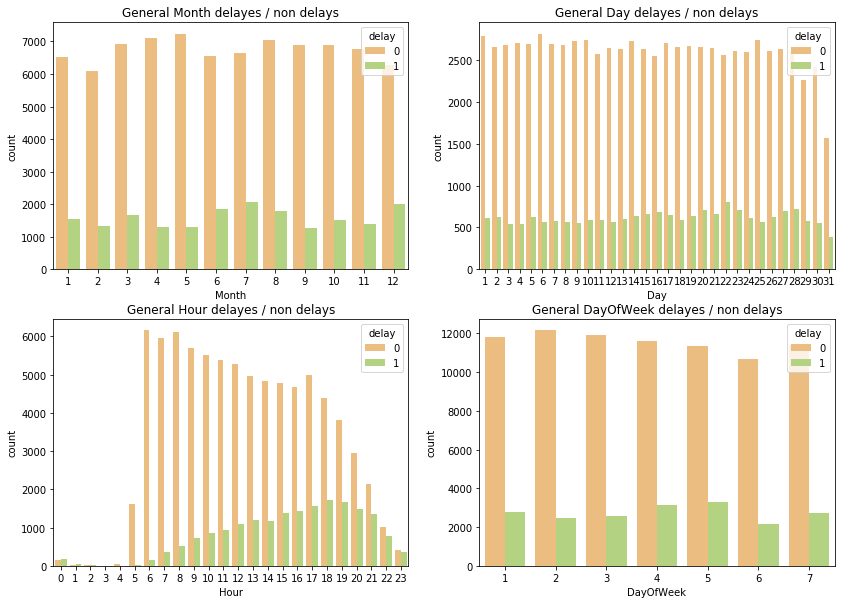

In [17]:
fields = ['Month', 'Day', 'Hour', 'DayOfWeek']

fig, axes = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(14)

for i in range(2):
    for j in range(2):
        axes[i,j].set_title('General ' + fields[i*2+j] + ' delayes / non delays')
        sns.countplot(x=fields[i*2+j], hue = 'delay', data=df, palette="RdYlGn", ax=axes[i,j])

Как можно увидеть из графиков, наиболее значимым признаком по сумме задержек явяются часы посадки

Ближе к вечеру количество задержек линейно возрастает. Пик числа задержек наблюдается в 18:00

  
  
  

Построим аналогичный график по минутам

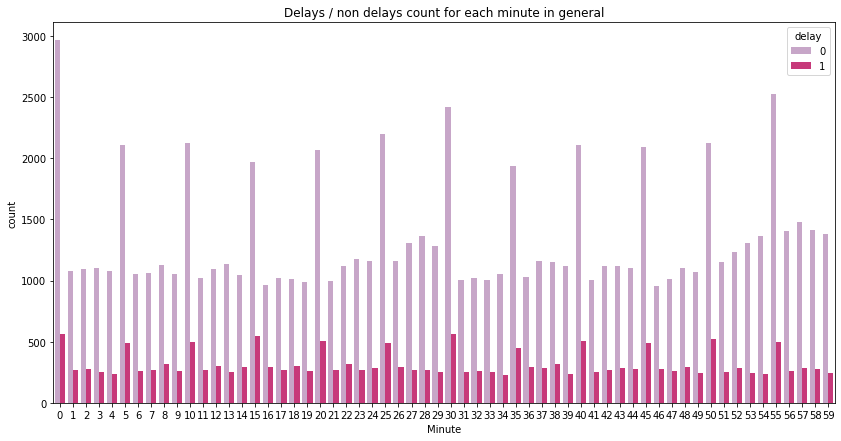

In [18]:
fig = plt.figure(figsize= (14,7))
sns.countplot(x='Minute', hue = 'delay', data=df, palette="PuRd");
plt.title('Delays / non delays count for each minute in general');

Заметим, что во время кратное 5 минутам совершает посадку большее количество самолетов, соответственно и задержек пропорционально больше 

In [19]:
minute_relative_delay = df.groupby('Minute')[['delay']].sum() / df.groupby('Minute')[['delay']].count()
minute_relative_delay = minute_relative_delay[['delay']]

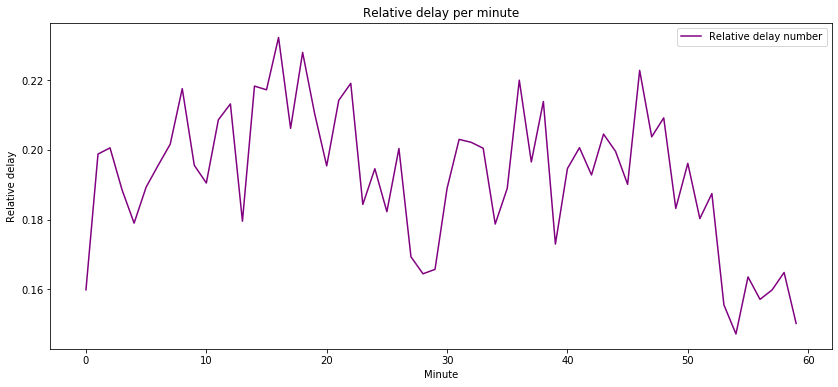

In [20]:
ax = minute_relative_delay['delay'].plot.line(color='purple', label='Relative delay number', figsize=(14,6))
ax.set_ylabel('Relative delay')

plt.title('Relative delay per minute')
plt.legend();

Количество задержек отнесенное к общему числу посадок по минутам уменьшается к концу часа

Построим график нормированного количества полетов и задержек по всем дням 2000 года

In [21]:
def relative_delay_flights(df):
    date_delay = pd.DataFrame({'date': df['Date'].apply(lambda d: d.date()),
                               'delay': df['delay']})

    date_flights = date_delay.groupby('date')[['delay']].count()

    date_flights['delay'] = date_flights['delay'] / date_flights['delay'].max()

    date_delay = date_delay.groupby('date')[['delay']].sum()
    date_delay['delay'] = date_delay['delay'] / date_delay['delay'].max()

    delay_mean = date_delay['delay'].mean()
    
    return date_delay, date_flights

In [22]:
def plot_relative_delay_flights(date_delay, date_flights=None):
    
    rollmean = date_delay.rolling(20).mean()
    plt.plot(rollmean, color='orange')
    
    if date_flights is not None:
        date_flights['delay'].plot.line(color='green', label='Normilied flights number')
    date_delay['delay'].plot.line(color='purple', label='Normilied delay number')
    
    delay_mean = date_delay['delay'].mean()
    
    plt.hlines(delay_mean, date_delay.index[0], date_delay.index[-1], linestyle = '--',\
               color='purple', label='Mean of normilied delay')
    plt.legend()
    plt.title('Normilized delays num and flights num per day')

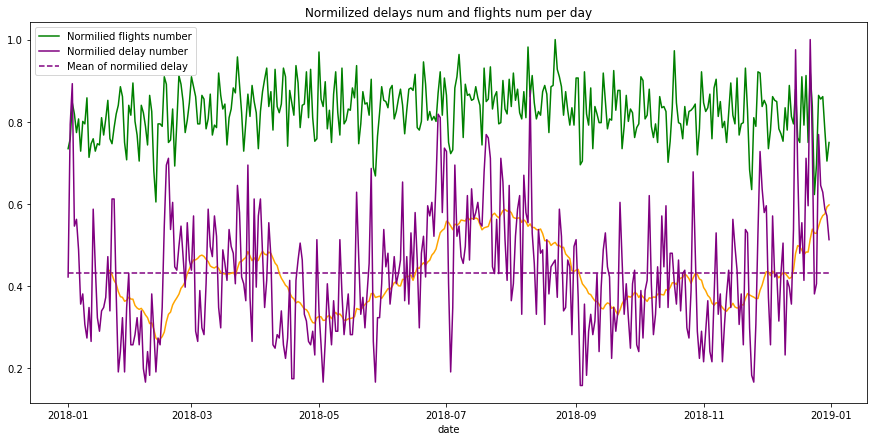

In [23]:
fig = plt.figure(figsize= (15,7))
date_delay, date_flights = relative_delay_flights(df)
plot_relative_delay_flights(date_delay, date_flights)

Заметим что в летние месяцы (06, 07, 08) задержек больше независимо от числа полетов, так же небольшое увеличение числа задержек наблюдается в конце декабря и начале января. 

Такое изменение числа задержек можно обусловить наличием праздников и каникул в это время 

Построем график распределения задержек по расстояния и времени посадки

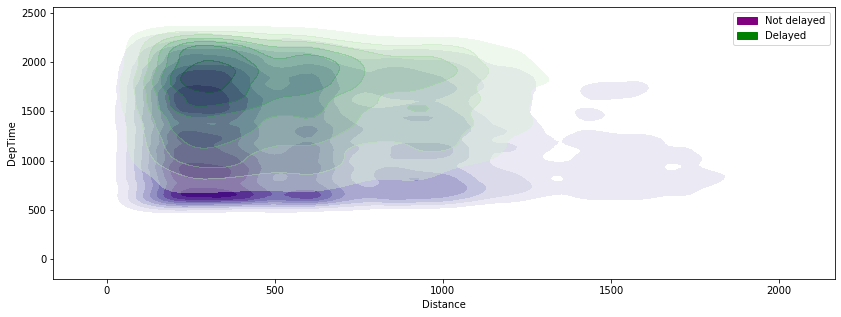

In [24]:
fig = plt.figure(figsize= (14,5))
q = df[['Distance']].quantile(0.95)
new_df = df[df.Distance < q[0]]

sns.kdeplot(new_df[new_df.delay == 0]['Distance'], new_df[new_df.delay == 0]['DepTime'], color='purple',\
            shade=True, cmap="Purples", shade_lowest=False, alpha = 1, legend=True, label='Not delayed')

sns.kdeplot(new_df[new_df.delay == 1]['Distance'], new_df[new_df.delay == 1]['DepTime'], color='green',\
            shade=True, cmap = "Greens", shade_lowest=False, alpha = 0.4, legend=True, label='Delayed')

plt.legend();

Можно еще раз убедиться что задерки происходят в вечернее время

Найдем аэропорты с наибольшим числом задержек

In [25]:
dest_info = df.groupby('Dest')[['delay']].sum()
dest_info.reset_index(inplace=True)
dest_info = dest_info.sort_values(by=['Dest'])

airport_counts = np.unique(df['Dest'], return_counts=True)

airport_counts = pd.DataFrame({'airport': airport_counts[0],
                               'flight_count': airport_counts[1]})

airpots_info = pd.DataFrame({'airport': dest_info['Dest'],
                             'unified_delay' : (dest_info['delay']) / airport_counts['flight_count'],
                             'flights_number': airport_counts['flight_count']})

airports_info = airpots_info.sort_values(by=['unified_delay'], ascending=False)

airports_info.reset_index(inplace=True, drop=True)
airports_info.describe()

,unified_delay,flights_number
count,289.000000,289.000000
mean,0.206133,346.020761
std,0.108651,739.527162
min,0.000000,1.000000
25%,0.157519,24.000000
50%,0.200000,65.000000
75%,0.250000,268.000000
max,1.000000,5795.000000


In [26]:
q = airports_info[['flights_number']].quantile(0.50)

bad_airports = airports_info[airports_info.flights_number > q[0]]

In [27]:
q = bad_airports[['unified_delay']].quantile(0.95)

bad_airports = bad_airports[bad_airports.unified_delay > q[0]]

In [28]:
def filter_airports(df, airports):

    index_list = [i for airport in airports for i in df[df.Dest == airport].index]
    return df.iloc[index_list]

In [29]:
bad_airports_df = filter_airports(df, bad_airports['airport'])
bad_airports_df

,Month,Day,Hour,Minute,DayOfWeek,Distance,UniqueCarrier,Origin,Dest,delay,DepTime,Date
2438,2,20,19,49,1,139,OO,ORD,MLI,0,1949,2018-02-20 19:49:00
4332,10,18,10,10,3,751,OO,DEN,MLI,0,1010,2018-10-18 10:10:00
6085,4,22,19,5,6,751,OO,DEN,MLI,0,1905,2018-04-22 19:05:00
7074,2,4,11,23,5,633,FL,ATL,MLI,0,1123,2018-02-04 11:23:00
7361,4,17,9,50,7,350,OH,CVG,MLI,0,950,2018-04-17 09:50:00
...,...,...,...,...,...,...,...,...,...,...,...,...
97943,6,13,20,5,1,718,OH,JFK,SAV,1,2005,2018-06-13 20:05:00
98122,11,28,15,56,1,708,XE,EWR,SAV,0,1556,2018-11-28 15:56:00
98201,12,2,12,33,5,215,EV,ATL,SAV,0,1233,2018-12-02 12:33:00
98661,11,30,9,56,4,215,DL,ATL,SAV,1,956,2018-11-30 09:56:00


In [30]:
#отбросим слишком большие расстояния для большей наглядности

q = bad_airports_df[['Distance']].quantile(0.99)

bad_airports_df = bad_airports_df[bad_airports_df.Distance < q[0]] 

In [31]:
bad_airports_df.replace(bad_airports_df['DepTime'], bad_airports_df['DepTime'].\
                        apply(lambda t: t//100*100 + int((t%100)/60*100)), inplace=True)

Построим то же распределение числа задержек по времени и расстоянию для "плохих" аэропортов

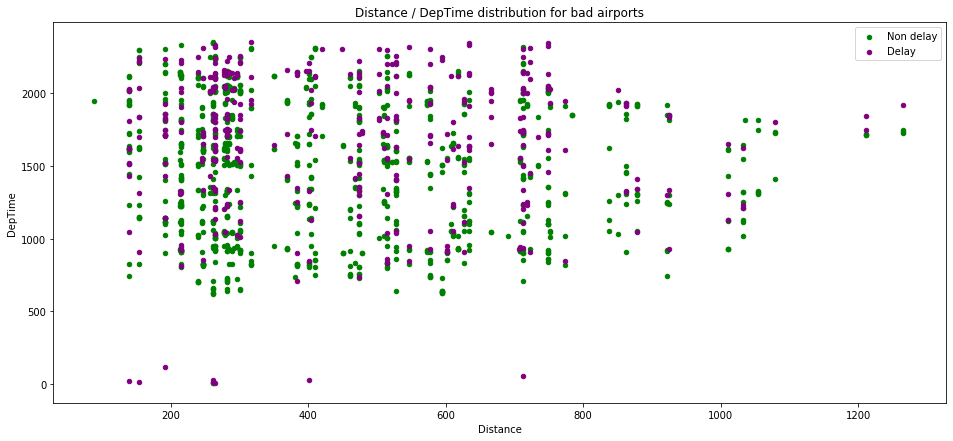

In [39]:
ax = bad_airports_df[bad_airports_df.delay==0].plot.scatter(x='Distance', y='DepTime', figsize=(16,7),\
                                                       color='Green', label='Non delay')

bad_airports_df[bad_airports_df.delay==1].plot.scatter(x='Distance', y='DepTime', figsize=(16,7),\
                                                            color='Purple', label='Delay', ax=ax)

plt.title('Distance / DepTime distribution for bad airports');

Заметим что задержки происходят в основном на малых дистанциях и наибольшее число задержек сконцентрировано в 20-21 час, то есть в более позднее время по сравнению c распределением всех данных

# Проверка Гипотез

In [33]:
df

,Month,Day,Hour,Minute,DayOfWeek,Distance,UniqueCarrier,Origin,Dest,delay,DepTime,Date
0,8,21,19,34,7,732,AA,ATL,DFW,0,1934,2018-08-21 19:34:00
1,4,20,15,48,3,834,US,PIT,MCO,0,1548,2018-04-20 15:48:00
2,9,2,14,22,5,416,XE,RDU,CLE,0,1422,2018-09-02 14:22:00
3,11,25,10,15,6,872,OO,DEN,MEM,0,1015,2018-11-25 10:15:00
4,10,7,18,28,6,423,WN,MDW,OMA,1,1828,2018-10-07 18:28:00
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5,4,16,18,3,199,OO,SFO,RDD,0,1618,2018-05-04 16:18:00
99996,1,18,8,4,3,884,CO,EWR,DAB,0,804,2018-01-18 08:04:00
99997,1,24,19,1,2,1076,NW,DTW,IAH,0,1901,2018-01-24 19:01:00
99998,4,27,15,15,4,140,MQ,DFW,GGG,0,1515,2018-04-27 15:15:00


### Параметрические критерии 

#### Z-критерий для несвязанных выборок

Проверим предположение о том, что доля задержек в пятницу больше доли задержек в среду

Сформулируем гипотезы:

H0 - доли задержек в пятницу и среду одинаковы   
H1 - доля задержек в среду меньше чем в пятницу


In [34]:
flights = df[['DayOfWeek', 'delay']].groupby('DayOfWeek').count().values.ravel()
delays = df[['DayOfWeek', 'delay']].groupby('DayOfWeek').sum().values.ravel()

days_of_week_delays = pd.DataFrame({'Flights': flights,
                                    'Delays': delays})

days_of_week_delays

,Flights,Delays
0,14569,2774
1,14604,2451
2,14508,2567
3,14736,3117
4,14657,3285
5,12829,2145
6,14097,2705


In [35]:
count = np.array([days_of_week_delays['Delays'][2], days_of_week_delays['Delays'][4]])
nobs = np.array([days_of_week_delays['Flights'][2], days_of_week_delays['Flights'][4]])

proportions_ztest(count, nobs, alternative='smaller')

(-10.060946176902407, 4.1102224926302764e-24)

p < 0.05 следовательно принимаем нулевую гипотезу

### Непараметрические критерии

Проверим отличается ли среднее количество задержек в день по летним месяцам от среднего количества по остальным месяцам 

(большее количество задержек летом может быть обусловлено большей загруженностью самолетов в связи с каникулами и хорошей погодой, или наооборот хорошая погода позволяет прокладывать более прямые маршруты полетов - не нужно облетать облака и так далее)

#### Критерий Манна-Уитни

Сформулируем гипотезы:

H0 - среднее количество задержек в день не отличается  
H1 - в летние месяцы среднее количество задержек в день больше чем в остьальные месяцы





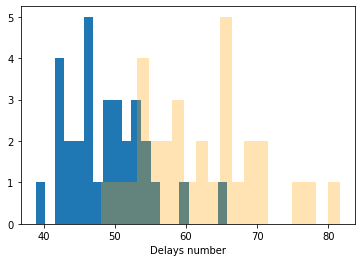

In [36]:
date_delay = df[['Month', 'Day', 'delay']]

date_delay = date_delay.groupby(['Month', 'Day']).sum()
date_delay.reset_index(inplace = True)
                       
summer_month = date_delay[(date_delay.Month == 6) | (date_delay.Month == 7) | (date_delay.Month == 8)]
other_month = date_delay[(date_delay.Month != 6) & (date_delay.Month != 7) & (date_delay.Month != 8)]

summer_month = summer_month[['Day', 'delay']].groupby('Day').mean()
other_month = other_month[['Day', 'delay']].groupby('Day').mean()

plt.hist(other_month['delay'], 20)
plt.hist(summer_month['delay'], 20, color='orange', alpha= 0.3)
plt.xlabel('Delays number');

In [37]:
stats.mannwhitneyu(other_month['delay'], summer_month['delay'], alternative = 'greater')

MannwhitneyuResult(statistic=83.5, pvalue=0.9999999890958824)

Получаем что pvalue > 0.05 значит нулевая гипотеза отвергается  

И действительно в летние месяцы среднее количество задержек в день больше чем в остальные месяцы

# Выводы

Я провел исследование датасета с данными по авиаперелетам Америки за 2018 год, целью исследования было прогнозирование задержек самолетов при посадке. Для этого была произведена первичная обработка данных, рассмотрены и визуализированы различные зависимости, такие как колчество задержек / час, относительная задержка / минута, время прибытия / расстояние и другие. Был произведен отбор "худших" аэропортов и для них построена точечная диаграмма времени прибытия в зависимости от расстояния. Опираясь на построенные графики можно сделать вывод, что наибольшее число задержек происходит в вечернее время (17 - 18 - 19 часов), на коротких дистанциях, в летние месяцы.

Мною были проверены две гипотезы: 
1. Доля задержек в среду меньше чем в пятницу.
2. В летние месяцы среднее количество задержек в день больше чем в остьальные месяцы

Только вторая оказалась верной

Таким образом при прогнозировании задержки стоит в большей степени обратить внимание на время прибытия, время года, расстояние между аэропортами и на позицию аэропорта прибытия в рейтинге "плохих" аэропортов. 

In [38]:
# colors = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', \
#           'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r','Dark2', 'Dark2_r', \
#           'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', \
#           'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r',\
#           'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', \
#           'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples',\
#           'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu',\
#           'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', \
#           'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', \
#           'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r',\
#           'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r',\
#           'brg', 'brg_r', 'bwr','bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm',\
#           'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r',\
#           'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r',\
#           'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', \
#           'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r',\
#           'gnuplot_r', 'gray', 'gray_r','hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', \
#           'icefire_r', 'inferno', 'inferno_r', 'magma', 'magma_r', 'mako', 'mako_r',\
#           'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', \
#           'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket',\
#           'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer',\
#           'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r',\
#           'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', \
#           'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag',\
#           'vlag_r', 'winter', 'winter_r']

# fig, axes = plt.subplots(13, 13)

# fig.set_figheight(20)
# fig.set_figwidth(20)
# data = pd.DataFrame({'X': [0,1],
#                      'Val': [0,1]})
# for i in range(13):
#     for j in range(13):
#         axes[i,j].set_title(colors[i*13+j])
#         sns.countplot(x='X', data=data, palette=colors[i*13+j], ax=axes[i,j]);
#         axes[i,j].set_xlabel('')
#         axes[i,j].set_ylabel('')
#         plt.subplots_adjust(wspace=0.7, hspace=0.7)